# Updating Behaviour Analysis
- Did rewrite of sections of path processing code to enable additional analysis to be conducted
- Now reading circadian DB gives back annotated paths divided into day and night periods

In [71]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas, networkx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.12 64bit [GCC 5.4.0 20160609]
IPython 5.7.0
OS Linux 4.13.0 41 generic x86_64 with Ubuntu 16.04 xenial
numpy 1.14.3
scipy 1.1.0
matplotlib 2.2.2
pandas 0.23.0
networkx 2.1
Thu May 24 02:52:46 2018 AEST

In [72]:
import os
import sys
import numpy as np
import pandas as pd
import shelve
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
sys.path.append("/home/jack/Dev/BeeUnique/src")

In [7]:
from Processor.Utils.fileutils import create_dir_check_exists
from Processor.Utils.imageutils import calc_distance
from Processor.Utils import constants

from Processor.Utils.pathmetrics import calc_path_metrics

## Explore Circadian Path Directory

In [8]:
experiment_directory = '/home/jack/Data/Caffeine_Unique_Tags'

db_dir = create_dir_check_exists(experiment_directory, 'db')
circadian_db_file = os.path.join(db_dir, 'circadian_metrics.db')

In [10]:
from Processor.Utils.imageutils import combine_night_day_bg

image_directory_path = os.path.join(experiment_directory, 'background')
night_day_bg_images = combine_night_day_bg(image_directory_path)

In [11]:
circadian_db = shelve.open(circadian_db_file)
for tag_class in circadian_db.keys():
    print(tag_class)

circadian_db.close()

0
11
13
15
17
19
20
22
24
26
28
31
33
35
37
39
40
42
44
46
48
4
51
6
8
10
12
14
16
18
1
21
23
25
27
29
30
32
34
36
38
3
41
43
45
47
49
50
5
7
9


## Metrics data
- Each tag_class has a dictionary of night/day keys
- Each key has a list for time period
- Each time period has a metrics dictionary

### Metrics Data Structure
- all_activity_grouped_by_type = []
    - speed_group = 'absent'
        - {'activity': 'absent', 'num_seconds': num_seconds}
    - speed_group = 'moving'
        - {'activity': speed_group}
    - speed_group = 'motionless'
        - {'activity': speed_group, 'num_seconds': current_window['seconds_motionless']}
- all_distances_per_second_window = []
    - List of all distances travelled per second
- all_reappearance_data = []
    - {'same_loc_disappeared': same_loc_disappeared, 'num_seconds': num_seconds, 'x': path['x'], 'y': path['y']}
- all_perimeter_data = []
    - {'seconds_present': 0, 'start_coord': {'x': None, 'y': None}, 'center_coord': {'x': None, 'y': None},'coords': [], 'distances_per_second': [], 'reappearance_data': []}
- cells_visited_speed_groups = {'all': {}, 'moving': {}, 'motionless': {}}
    - Increment yx coord for however many times visited
- all_locs_by_sec = {}
    - Keys are the second that has passed in time period
    - Maps to {'x': x, 'y': y, 'tag_class': tag_class}
    - Where tag_class was at end of second
    
### Tag Class Groupings
- constants.QUEEN_CLASS
- constants.TREATMENT_CLASSES
- constants.CONTROL_CLASSES

## Calculate Metrics

In [13]:
%%time

circadian_db = shelve.open(circadian_db_file)

tag_class_circadian_metrics = {}
 
# remember tag_class is an integer cast to string
for tag_class in circadian_db.keys():
    print(tag_class)
    bee_circadian_paths = circadian_db[tag_class]
    # cast tag_class back to int
    tag_class_circadian_metrics[int(tag_class)] = {'night': [], 'day': []}
    for night_day in bee_circadian_paths.keys():
        for night_day_time_period_paths in bee_circadian_paths[night_day]:
            metrics = calc_path_metrics(night_day_time_period_paths, int(tag_class))
            tag_class_circadian_metrics[int(tag_class)][night_day].append(metrics)

0
11
13
15
17
19
20
22
24
26
28
31
33
35
37
39
40
42
44
46
48
4
51
6
8
10
12
14
16
18
1
21
23
25
27
29
30
32
34
36
38
3
41
43
45
47
49
50
5
7
9
CPU times: user 58min 43s, sys: 11.2 s, total: 58min 54s
Wall time: 58min 44s


## Import plots and generate previous figures

In [14]:
from Processor.Utils.graphics import plot_path_bg, plot_histogram, plot_line, plot_seconds_of_activity, plot_scatter

plots_dir = create_dir_check_exists(experiment_directory, 'plots')

path_bg_dir = create_dir_check_exists(plots_dir, 'path_bg')
distances_per_second_window_dir = create_dir_check_exists(plots_dir, 'distances_per_second_window')
seconds_spent_in_perimeter_dir = create_dir_check_exists(plots_dir, 'seconds_spent_in_perimeter')
consecutive_seconds_motionless_dir = create_dir_check_exists(plots_dir, 'consecutive_seconds_motionless')
consecutive_seconds_motionless_path_dir = create_dir_check_exists(plots_dir, 'consecutive_seconds_motionless_path')
heatmaps_dir = create_dir_check_exists(plots_dir, 'heatmaps')

### Seconds activity plots

In [16]:
seconds_activity = []

for i in range(len(tag_class_circadian_metrics[constants.QUEEN_CLASS]['night'])):
    night_metrics = tag_class_circadian_metrics[constants.QUEEN_CLASS]['night'][i]
    day_metrics = tag_class_circadian_metrics[constants.QUEEN_CLASS]['day'][i]
    
    night_period_str = str(i) + '_0_' + 'night'
    day_period_str = str(i) + '_1_' + 'day'
    night_bg_image = night_day_bg_images['night'][i]
    day_bg_image = night_day_bg_images['day'][i]
    
    night_activity = night_metrics['all_activity_grouped_by_type']
    num_seconds_to_fill = constants.SECONDS_IN_12_HOURS - sum([a['num_seconds'] if a['num_seconds'] > 0 else 1 for a in night_activity])
    seconds_activity.append({'activity': 'filler', 'num_seconds': num_seconds_to_fill})
    seconds_activity.extend(night_activity)
        
    day_activity = day_metrics['all_activity_grouped_by_type']
    num_seconds_to_fill = constants.SECONDS_IN_12_HOURS - sum([a['num_seconds'] if a['num_seconds'] > 0 else 1 for a in day_activity])
    seconds_activity.append({'activity': 'filler', 'num_seconds': num_seconds_to_fill})
    seconds_activity.extend(day_activity)
    
time_period_str = "all_night_day"
file_name = os.path.join(consecutive_seconds_motionless_path_dir, time_period_str + '.png')
plot_seconds_of_activity(seconds_activity, file_name)



KeyError: 'num_seconds'

### Speeds

In [ ]:
for i in range(len(tag_class_circadian_metrics[constants.QUEEN_CLASS]['night'])):
    night_metrics = tag_class_circadian_metrics[constants.QUEEN_CLASS]['night'][i]
    day_metrics = tag_class_circadian_metrics[constants.QUEEN_CLASS]['day'][i]
    
    night_period_str = str(i) + '_0_' + 'night'
    day_period_str = str(i) + '_1_' + 'day'
    night_bg_image = pm.night_day_bg_images['night'][i]
    day_bg_image = pm.night_day_bg_images['day'][i]
    
    for speed_group in night_metrics.cells_visited_speed_groups.keys():
        speed_group_heatmap_dir = create_dir_check_exists(heatmaps_dir, speed_group)
        file_name = os.path.join(speed_group_heatmap_dir, night_period_str)
        all_coords_spread, class_presence_spread = pm.calc_heatmaps(night_metrics.cells_visited_speed_groups[speed_group], night_bg_image, file_name)
    
    for speed_group in day_metrics.cells_visited_speed_groups.keys():
        speed_group_heatmap_dir = create_dir_check_exists(heatmaps_dir, speed_group)
        file_name = os.path.join(speed_group_heatmap_dir, day_period_str)
        all_coords_spread, class_presence_spread = pm.calc_heatmaps(day_metrics.cells_visited_speed_groups[speed_group], day_bg_image, file_name)

### Motionless

In [ ]:
seconds_motionless = []

for i in range(len(tag_class_circadian_metrics[constants.QUEEN_CLASS]['night'])):
    night_metrics = tag_class_circadian_metrics[constants.QUEEN_CLASS]['night'][i]
    day_metrics = tag_class_circadian_metrics[constants.QUEEN_CLASS]['day'][i]
    
    night_period_str = str(i) + '_0_' + 'night'
    day_period_str = str(i) + '_1_' + 'day'
    night_bg_image = pm.night_day_bg_images['night'][i]
    day_bg_image = pm.night_day_bg_images['day'][i]
    
    file_name = os.path.join(distances_per_second_window_dir, time_period_str + '.png')
    plot_histogram(metrics.all_distances_per_second_window, 'Distance per second', file_name)
    
    file_name = os.path.join(seconds_spent_in_perimeter_dir, time_period_str + '.png')
    plot_histogram(metrics['seconds_spent_in_perimeter'], 'Seconds spent in perimeter', file_name)
    
     

In [ ]:
for motionless_data in metrics.all_motionless_data:
        seconds_motionless.append(motionless_data['seconds_motionless'])

file_name = os.path.join(consecutive_seconds_motionless_dir, time_period_str + '.png')
            plot_histogram(seconds_motionless, 'Consecutive seconds motionless', file_name)
    
file_name = os.path.join(consecutive_seconds_motionless_path_dir, time_period_str + '.png')

## Create Networks

In [85]:
WORKER_NUM_DAYS_ANALYSE = 7
QUEEN_NUM_DAYS_ANALYSE = 14

all_graphs = {'night': [], 'day': []}

for night_day in ['night', 'day']:
    print(night_day)
    for night_day_num in range(WORKER_NUM_DAYS_ANALYSE):
        print(night_day_num)
        all_bee_locs_by_sec = {}
        graphs = {'close': nx.MultiGraph(), 'same_side': nx.MultiGraph()}
        for tag_class in tag_class_circadian_metrics.keys():
            
            group = None
            if tag_class in constants.CONTROL_CLASSES:
                group = 'Control'
            elif tag_class in constants.TREATMENT_CLASSES:
                group = 'Treatment'
            elif tag_class == constants.QUEEN_CLASS:
                group = 'Queen'
            else:
                print('Error, cannot find tag_class')
            
            for proximity in graphs.keys():
                graphs[proximity].add_node(tag_class, total_secs_seen=0, group=group)
                      
            bee_locs_by_sec = tag_class_circadian_metrics[int(tag_class)][night_day][night_day_num]['all_locs_by_sec']
            
            for sec in bee_locs_by_sec.keys():
                for proximity in graphs.keys():
                    graphs[proximity].node[tag_class]['total_secs_seen'] += 1
                if sec in all_bee_locs_by_sec.keys():
                    all_bee_locs_by_sec[sec].append(bee_locs_by_sec[sec])
                else:
                    all_bee_locs_by_sec[sec] = [bee_locs_by_sec[sec]]
                      
                      
        secs_in_order = list(all_bee_locs_by_sec.keys())
        secs_in_order.sort()
        for sec in secs_in_order:
            bee_locs = all_bee_locs_by_sec[sec]
            # only need to calculate distance for each pair once
            bee_index_distance_calculated = []
            for i in range(len(bee_locs)):
                bee_loc = bee_locs[i]
                bee_index_distance_calculated.append(i)
                
                for j in range(len(bee_locs)):
                    if j not in bee_index_distance_calculated:
                        other_bee_loc = bee_locs[j]
                        distance = calc_distance(bee_loc['x'], bee_loc['y'], other_bee_loc['x'], other_bee_loc['y'])
                        for proximity in graphs.keys():
                            
                            if proximity == 'same_side' or distance < constants.TRIPLE_TAG_DIAMETER:
                                create_new_edge = True
                                if other_bee_loc['tag_class'] in graphs[proximity][bee_loc['tag_class']].keys():
                                    most_recent_edge_index = max(list(graphs[proximity][bee_loc['tag_class']][other_bee_loc['tag_class']].keys()))
                                    if sec - graphs[proximity][bee_loc['tag_class']][other_bee_loc['tag_class']][most_recent_edge_index]['last_sec_seen'] == 1:
                                        graphs[proximity][bee_loc['tag_class']][other_bee_loc['tag_class']][most_recent_edge_index]['last_sec_seen'] = sec
                                        graphs[proximity][bee_loc['tag_class']][other_bee_loc['tag_class']][most_recent_edge_index]['weight'] += 1
                                        graphs[proximity][bee_loc['tag_class']][other_bee_loc['tag_class']][most_recent_edge_index]['coords'][bee_loc['tag_class']]['x_path'].append(bee_loc['x'])
                                        graphs[proximity][bee_loc['tag_class']][other_bee_loc['tag_class']][most_recent_edge_index]['coords'][bee_loc['tag_class']]['y_path'].append(bee_loc['y'])
                                        graphs[proximity][bee_loc['tag_class']][other_bee_loc['tag_class']][most_recent_edge_index]['coords'][other_bee_loc['tag_class']]['x_path'].append(other_bee_loc['x'])
                                        graphs[proximity][bee_loc['tag_class']][other_bee_loc['tag_class']][most_recent_edge_index]['coords'][other_bee_loc['tag_class']]['y_path'].append(other_bee_loc['y'])

                                        create_new_edge = False
                                        
                                if create_new_edge:
                                    new_edge_index = graphs[proximity].add_edge(bee_loc['tag_class'], 
                                                                          other_bee_loc['tag_class'], 
                                                                          last_sec_seen=sec, 
                                                                          weight=1,
                                                                          coords= {bee_loc['tag_class']: {'x_path': [bee_loc['x']], 'y_path':[bee_loc['y']]}, other_bee_loc['tag_class']: {'x_path': [other_bee_loc['x']], 'y_path':[other_bee_loc['y']]}})

        all_graphs[night_day].append(graphs)

night
0
1
2
3
4
5
6
day
0
1
2
3
4
5
6


In [86]:
constants.QUEEN_CLASS

44

0
night


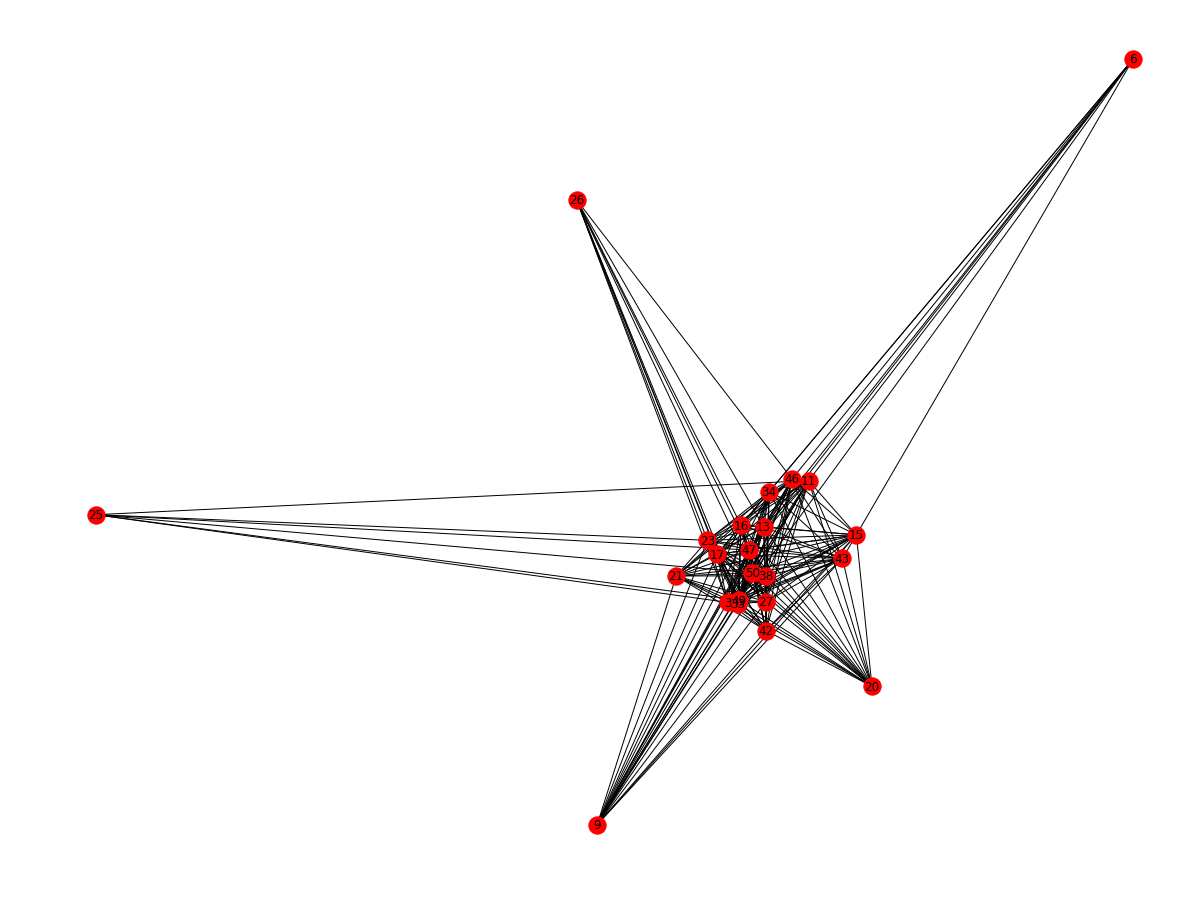

[('25', 6), ('26', 10), ('27', 19), ('20', 17), ('21', 17), ('23', 21), ('46', 21), ('47', 22), ('42', 19), ('43', 19), ('3', 20), ('6', 8), ('9', 18), ('11', 20), ('13', 21), ('38', 19), ('15', 20), ('17', 20), ('16', 21), ('33', 21), ('49', 22), ('50', 21), ('34', 20)]
[('25', 201), ('26', 2083), ('27', 157146), ('20', 24348), ('21', 66933), ('23', 103653), ('46', 119426), ('47', 183414), ('42', 104445), ('43', 67100), ('3', 108887), ('6', 556), ('9', 3202), ('11', 88026), ('13', 179301), ('38', 171307), ('15', 87835), ('17', 123175), ('16', 130048), ('33', 112402), ('49', 132382), ('50', 148411), ('34', 115129)]
[('25', 7), ('26', 104), ('27', 1648), ('20', 391), ('21', 568), ('23', 1333), ('46', 1539), ('47', 1627), ('42', 1065), ('43', 922), ('3', 1752), ('6', 14), ('9', 82), ('11', 1551), ('13', 1771), ('38', 1498), ('15', 1847), ('17', 1799), ('16', 1888), ('33', 1492), ('49', 1667), ('50', 1405), ('34', 1384)]
day


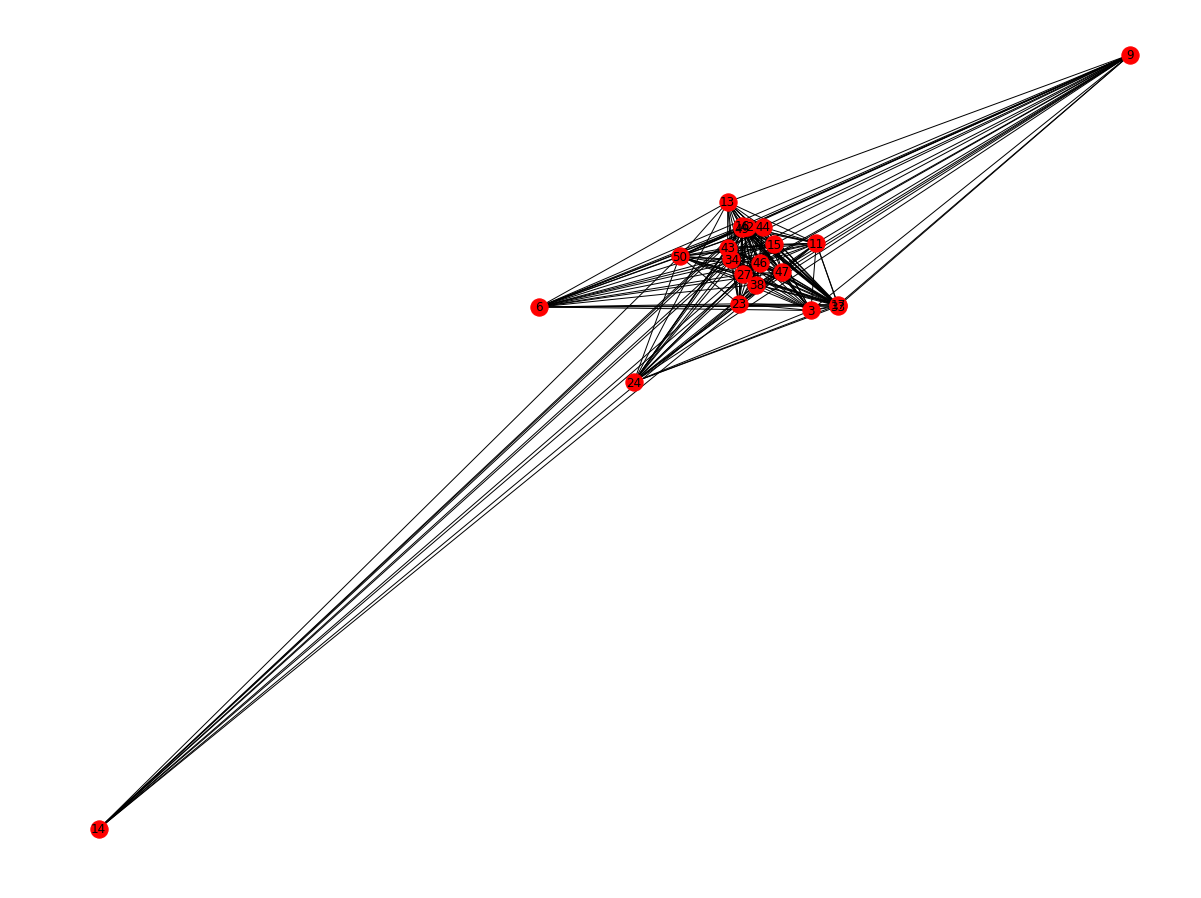

[('24', 19), ('27', 20), ('23', 20), ('46', 21), ('47', 21), ('44', 21), ('42', 21), ('43', 20), ('3', 20), ('6', 19), ('9', 20), ('11', 20), ('13', 20), ('38', 21), ('15', 21), ('14', 10), ('17', 20), ('16', 21), ('33', 20), ('49', 21), ('50', 21), ('34', 21)]
[('24', 60663), ('27', 194255), ('23', 186179), ('46', 257969), ('47', 236742), ('44', 319509), ('42', 150693), ('43', 161218), ('3', 165436), ('6', 90779), ('9', 11408), ('11', 176853), ('13', 149509), ('38', 199769), ('15', 187023), ('14', 648), ('17', 161454), ('16', 216340), ('33', 146325), ('49', 188470), ('50', 177093), ('34', 261027)]
[('24', 945), ('27', 2959), ('23', 2662), ('46', 3673), ('47', 2781), ('44', 4497), ('42', 2781), ('43', 3032), ('3', 4146), ('6', 1379), ('9', 317), ('11', 5084), ('13', 2159), ('38', 2572), ('15', 5778), ('14', 12), ('17', 2868), ('16', 3034), ('33', 2852), ('49', 3194), ('50', 3299), ('34', 3272)]
1
night


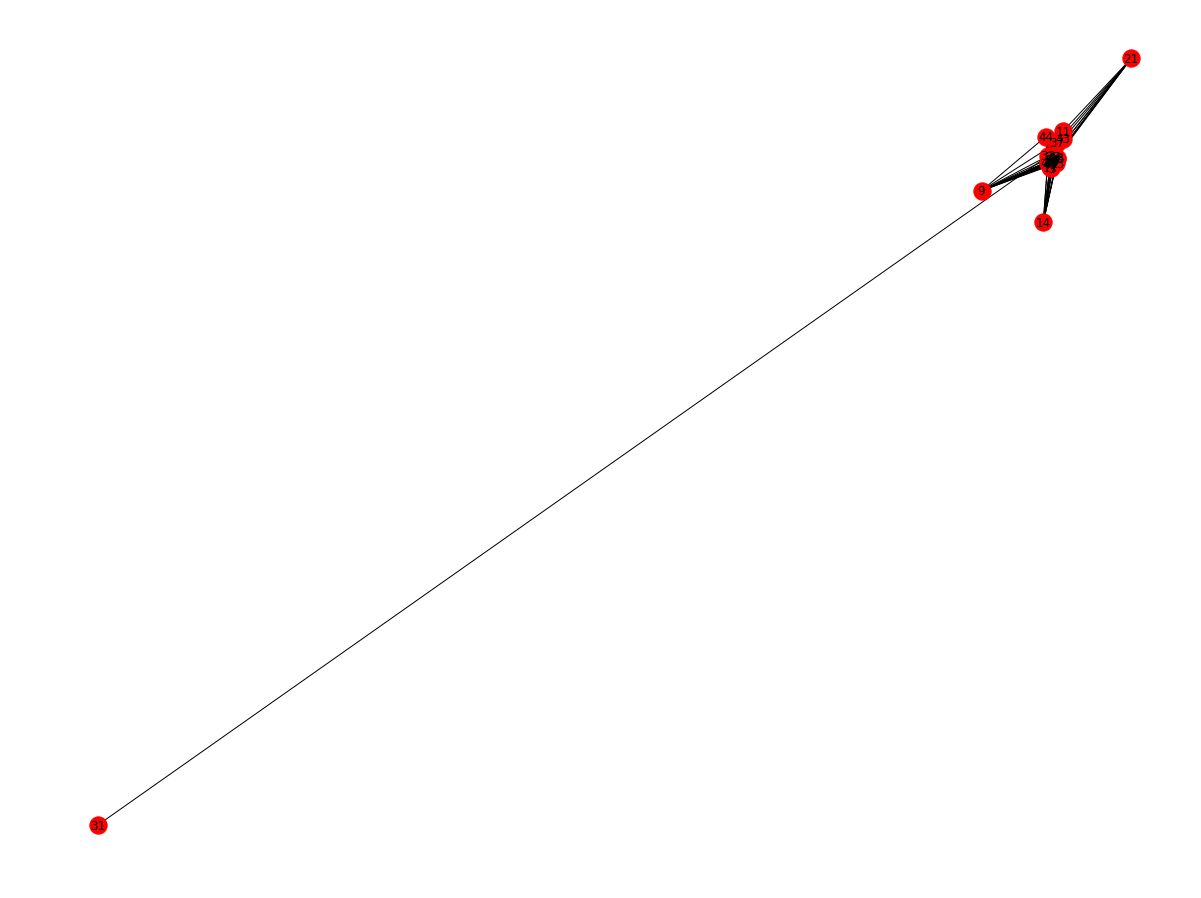

[('27', 22), ('21', 9), ('49', 21), ('46', 22), ('47', 22), ('44', 20), ('42', 22), ('43', 20), ('3', 20), ('6', 22), ('9', 16), ('11', 21), ('13', 21), ('38', 21), ('15', 22), ('14', 18), ('17', 20), ('16', 21), ('33', 22), ('31', 1), ('23', 21), ('37', 22), ('50', 21), ('34', 21)]
[('27', 233056), ('21', 727), ('49', 215026), ('46', 286811), ('47', 247382), ('44', 135519), ('42', 185657), ('43', 120552), ('3', 177202), ('6', 323555), ('9', 3273), ('11', 98146), ('13', 178498), ('38', 270316), ('15', 214126), ('14', 6093), ('17', 162172), ('16', 232873), ('33', 221975), ('31', 1), ('23', 220083), ('37', 102838), ('50', 256926), ('34', 175129)]
[('27', 3225), ('21', 15), ('49', 3218), ('46', 3453), ('47', 2727), ('44', 1913), ('42', 2511), ('43', 1954), ('3', 3672), ('6', 3755), ('9', 97), ('11', 3203), ('13', 1964), ('38', 2855), ('15', 5069), ('14', 71), ('17', 2786), ('16', 2790), ('33', 3099), ('31', 1), ('23', 2623), ('37', 1511), ('50', 3198), ('34', 2598)]
day


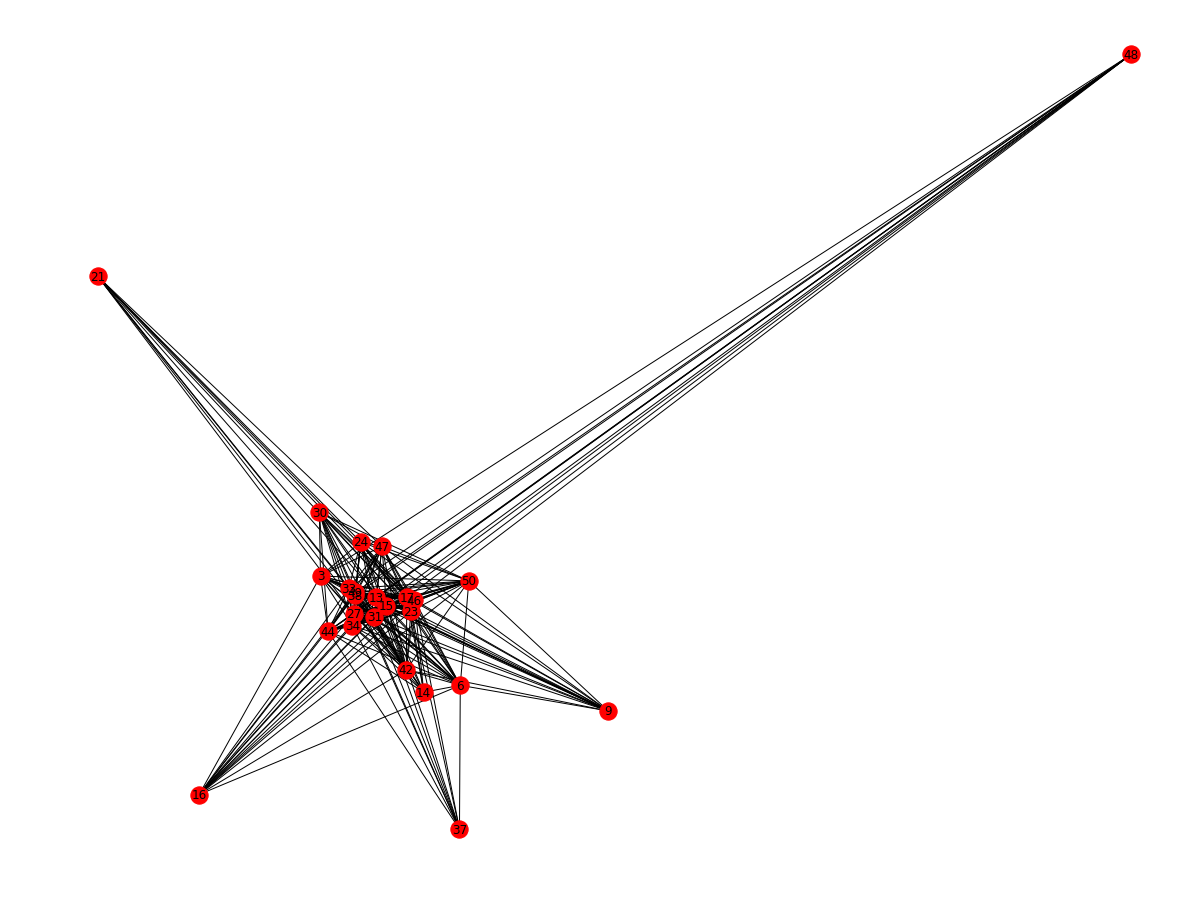

[('30', 15), ('24', 18), ('27', 23), ('21', 10), ('48', 11), ('23', 23), ('46', 24), ('47', 20), ('44', 19), ('42', 19), ('3', 21), ('6', 21), ('9', 17), ('13', 23), ('38', 24), ('15', 24), ('14', 12), ('17', 23), ('16', 15), ('33', 22), ('31', 22), ('49', 23), ('37', 10), ('50', 20), ('34', 23)]
[('30', 77913), ('24', 80737), ('27', 278885), ('21', 1089), ('48', 181), ('23', 256405), ('46', 243831), ('47', 133954), ('44', 144138), ('42', 107516), ('3', 142918), ('6', 100620), ('9', 10909), ('13', 171896), ('38', 259390), ('15', 178612), ('14', 47779), ('17', 203257), ('16', 5551), ('33', 222715), ('31', 208041), ('49', 152420), ('37', 6219), ('50', 135851), ('34', 219793)]
[('30', 1160), ('24', 1878), ('27', 4380), ('21', 16), ('48', 11), ('23', 3609), ('46', 3340), ('47', 1756), ('44', 1779), ('42', 1763), ('3', 3178), ('6', 1684), ('9', 249), ('13', 2423), ('38', 3450), ('15', 3830), ('14', 952), ('17', 3595), ('16', 176), ('33', 3994), ('31', 2733), ('49', 2398), ('37', 83), ('50',

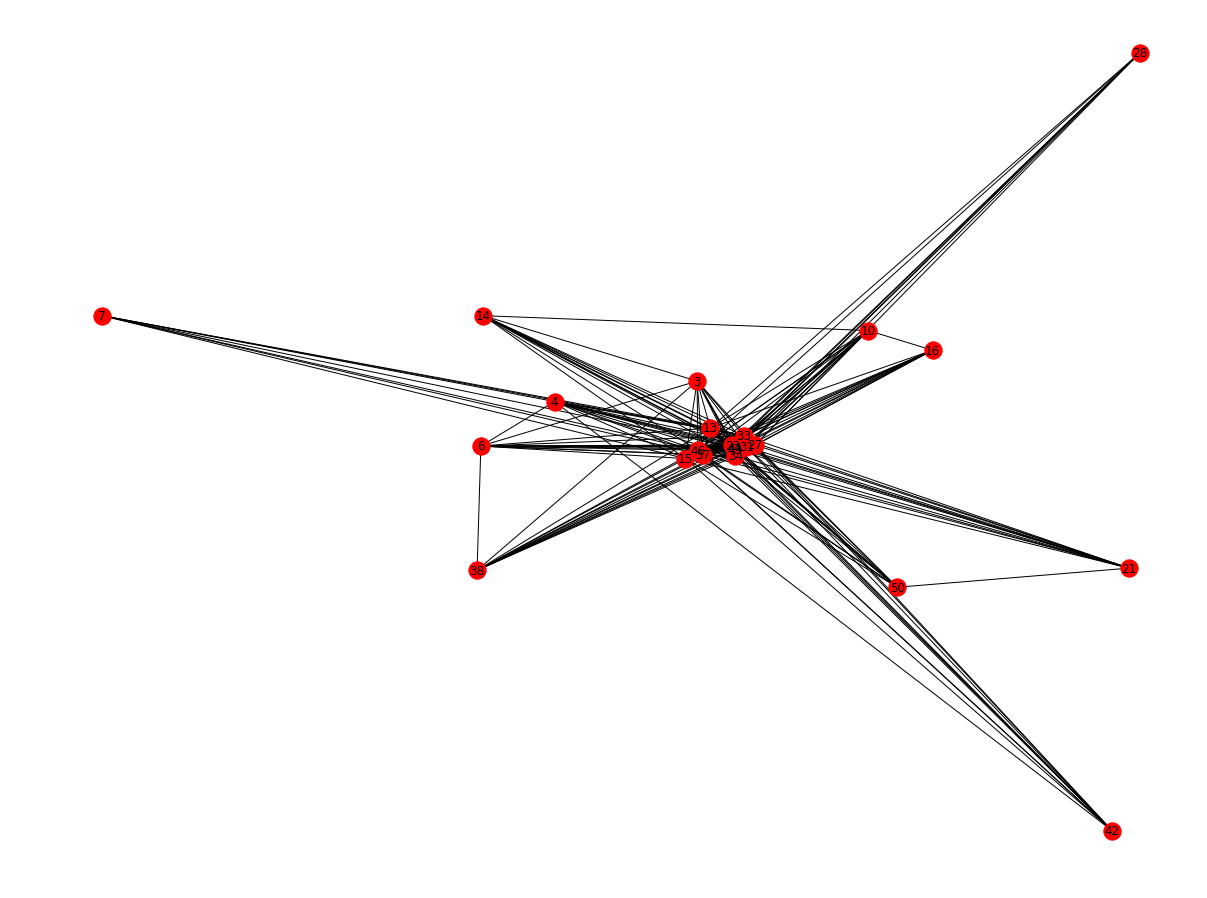

[('28', 8), ('27', 21), ('21', 12), ('49', 21), ('46', 22), ('44', 21), ('42', 11), ('3', 14), ('4', 14), ('7', 7), ('6', 14), ('10', 13), ('13', 22), ('38', 13), ('15', 21), ('14', 12), ('16', 12), ('33', 22), ('31', 20), ('23', 21), ('37', 20), ('50', 12), ('34', 21)]
[('28', 1425), ('27', 210504), ('21', 8501), ('49', 191236), ('46', 224418), ('44', 237118), ('42', 1535), ('3', 81764), ('4', 46077), ('7', 2773), ('6', 30197), ('10', 42802), ('13', 210363), ('38', 15905), ('15', 233301), ('14', 16439), ('16', 30128), ('33', 210646), ('31', 177479), ('23', 209869), ('37', 205627), ('50', 24755), ('34', 221386)]
[('28', 13), ('27', 2210), ('21', 233), ('49', 2622), ('46', 2529), ('44', 2693), ('42', 20), ('3', 1789), ('4', 900), ('7', 21), ('6', 1472), ('10', 558), ('13', 2071), ('38', 209), ('15', 2383), ('14', 336), ('16', 506), ('33', 3011), ('31', 2326), ('23', 2260), ('37', 3072), ('50', 387), ('34', 2591)]
day


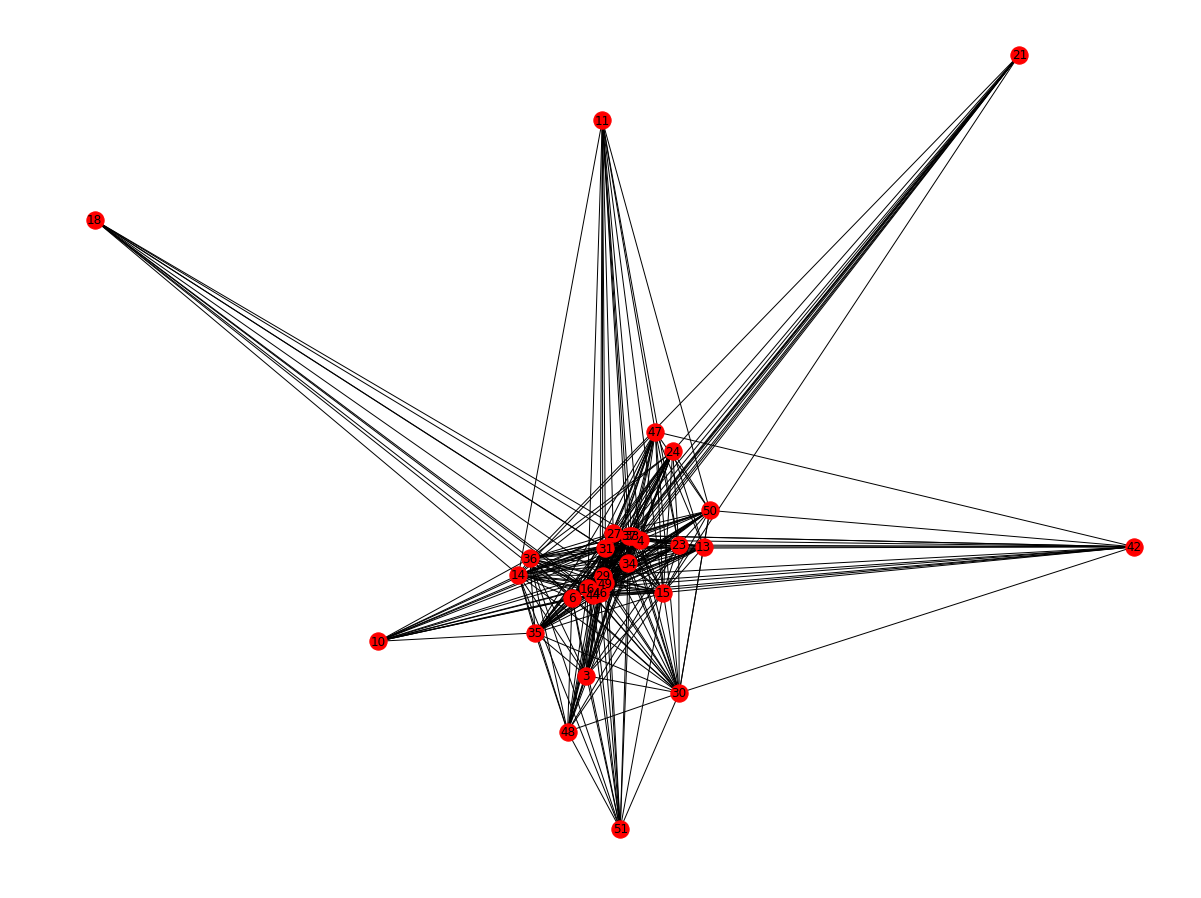

[('51', 14), ('36', 24), ('49', 27), ('24', 22), ('27', 25), ('21', 12), ('48', 18), ('23', 25), ('46', 28), ('47', 20), ('44', 26), ('42', 15), ('29', 28), ('3', 20), ('4', 25), ('6', 28), ('11', 14), ('10', 14), ('13', 21), ('15', 27), ('14', 27), ('16', 29), ('33', 27), ('18', 10), ('31', 28), ('30', 24), ('37', 28), ('50', 22), ('35', 25), ('34', 25)]
[('51', 10573), ('36', 97083), ('49', 202558), ('24', 51673), ('27', 206876), ('21', 390), ('48', 31632), ('23', 111167), ('46', 275569), ('47', 49670), ('44', 129202), ('42', 873), ('29', 190207), ('3', 41783), ('4', 172730), ('6', 143753), ('11', 1650), ('10', 9715), ('13', 89645), ('15', 113342), ('14', 79710), ('16', 269379), ('33', 160075), ('18', 490), ('31', 162199), ('30', 45184), ('37', 196257), ('50', 98017), ('35', 66532), ('34', 239022)]
[('51', 207), ('36', 1953), ('49', 5690), ('24', 1851), ('27', 3525), ('21', 24), ('48', 394), ('23', 2217), ('46', 4497), ('47', 757), ('44', 1794), ('42', 22), ('29', 4244), ('3', 887), 

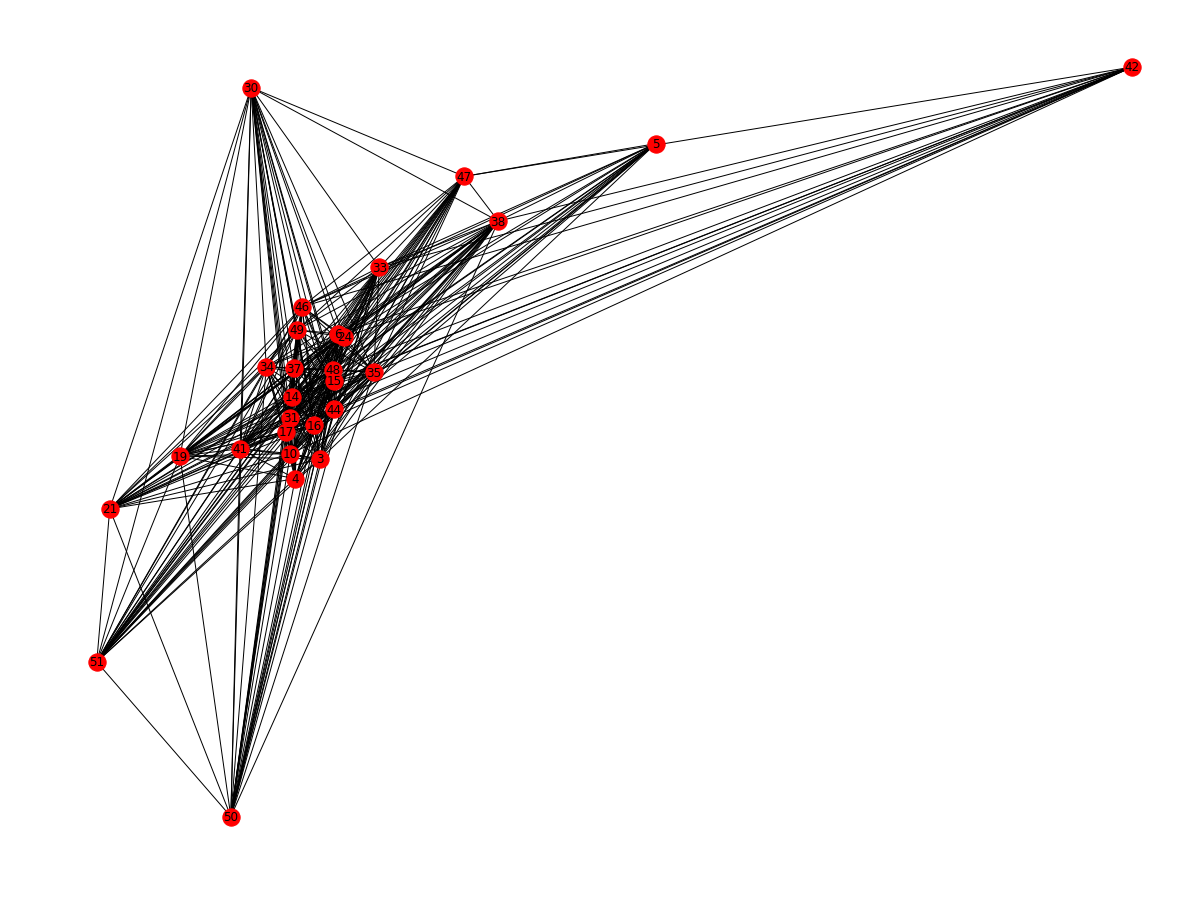

[('51', 25), ('24', 27), ('21', 22), ('48', 27), ('49', 25), ('46', 27), ('47', 22), ('44', 27), ('42', 15), ('41', 25), ('3', 26), ('5', 16), ('4', 25), ('6', 26), ('10', 27), ('38', 27), ('15', 27), ('14', 27), ('17', 27), ('16', 27), ('33', 24), ('31', 27), ('30', 25), ('37', 24), ('50', 24), ('35', 27), ('34', 23), ('19', 23)]
[('51', 72458), ('24', 203056), ('21', 81348), ('48', 318664), ('49', 263192), ('46', 433757), ('47', 87627), ('44', 428607), ('42', 960), ('41', 215100), ('3', 349033), ('5', 12013), ('4', 187317), ('6', 230726), ('10', 312340), ('38', 81944), ('15', 426124), ('14', 276265), ('17', 358195), ('16', 356983), ('33', 183659), ('31', 388925), ('30', 119768), ('37', 247509), ('50', 118891), ('35', 147021), ('34', 184713), ('19', 155945)]
[('51', 3148), ('24', 7708), ('21', 1547), ('48', 5657), ('49', 7482), ('46', 7279), ('47', 1392), ('44', 6146), ('42', 17), ('41', 5793), ('3', 6811), ('5', 242), ('4', 6118), ('6', 7272), ('10', 8492), ('38', 1377), ('15', 7949)

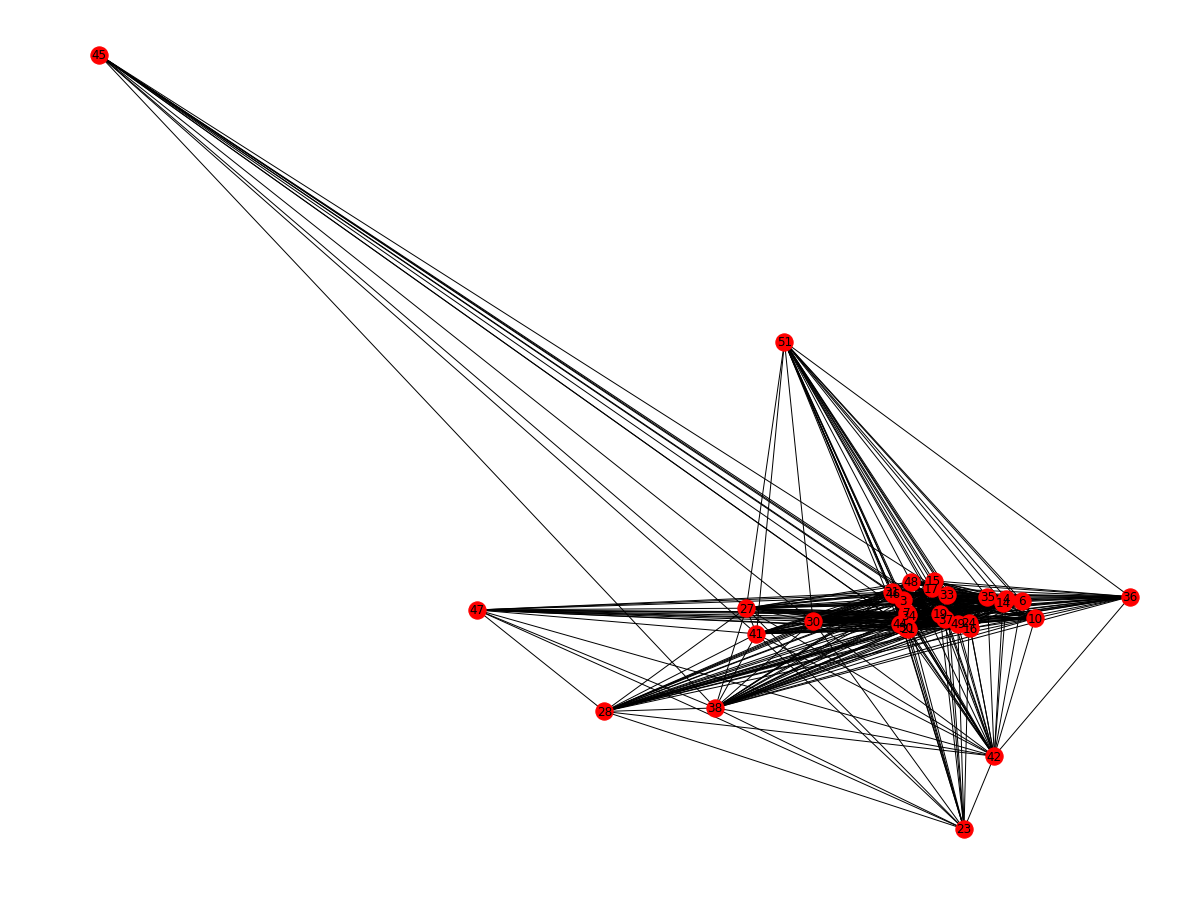

[('30', 32), ('28', 27), ('36', 27), ('24', 31), ('27', 31), ('21', 31), ('48', 29), ('23', 17), ('46', 32), ('47', 18), ('44', 30), ('45', 13), ('42', 29), ('41', 31), ('3', 29), ('4', 29), ('7', 30), ('6', 29), ('51', 26), ('10', 28), ('38', 30), ('15', 27), ('14', 29), ('17', 28), ('16', 28), ('19', 32), ('31', 32), ('49', 32), ('37', 32), ('50', 32), ('35', 29), ('34', 32), ('33', 32)]
[('30', 164273), ('28', 78892), ('36', 118830), ('24', 322375), ('27', 139042), ('21', 382254), ('48', 290741), ('23', 22038), ('46', 246952), ('47', 27249), ('44', 332752), ('45', 1139), ('42', 55191), ('41', 128806), ('3', 379487), ('4', 237829), ('7', 246706), ('6', 137758), ('51', 14510), ('10', 130733), ('38', 132030), ('15', 269301), ('14', 163462), ('17', 235268), ('16', 288198), ('19', 450649), ('31', 376675), ('49', 314087), ('37', 314018), ('50', 321517), ('35', 151515), ('34', 407378), ('33', 239879)]
[('30', 4206), ('28', 2000), ('36', 4868), ('24', 10663), ('27', 2832), ('21', 10456), ('

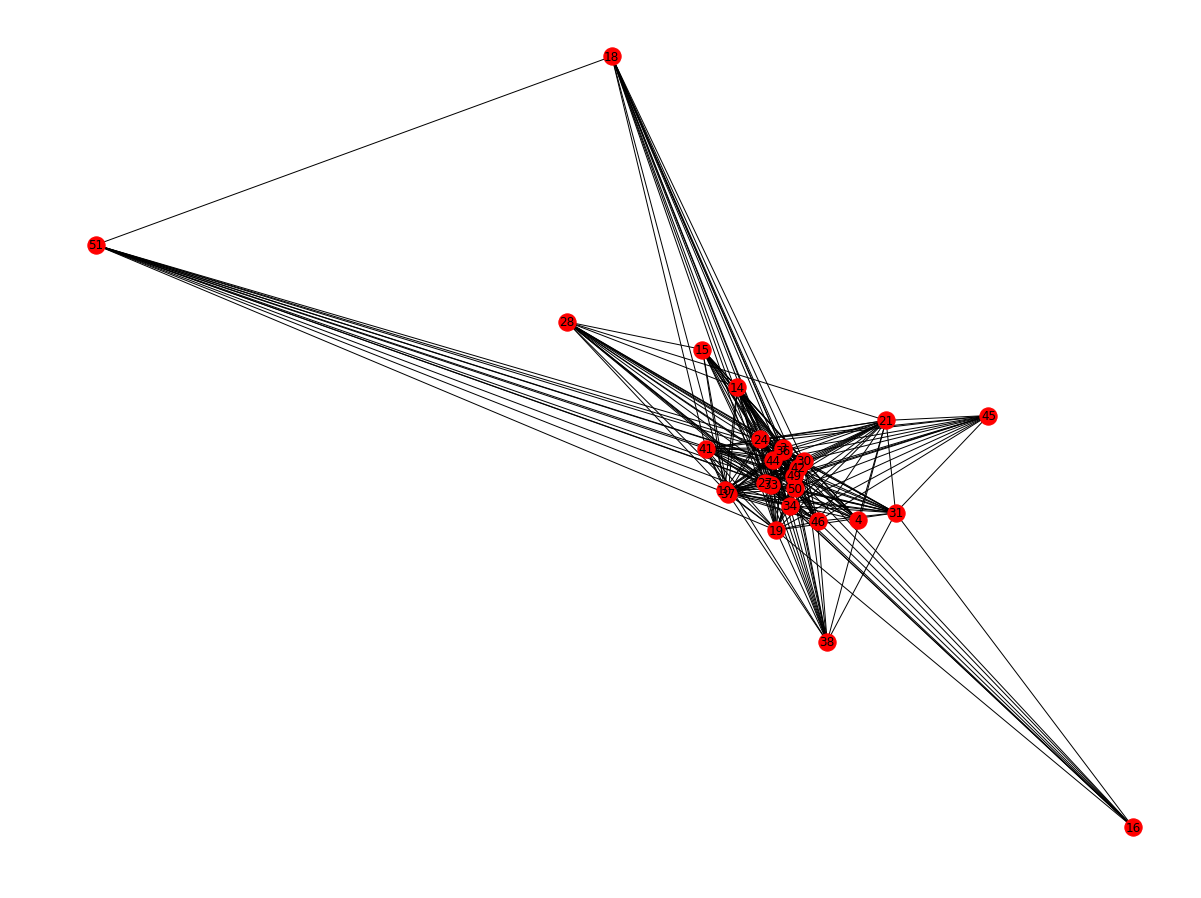

[('37', 22), ('36', 26), ('24', 25), ('27', 26), ('21', 20), ('49', 25), ('46', 22), ('44', 25), ('45', 14), ('42', 23), ('41', 21), ('3', 21), ('4', 13), ('28', 17), ('10', 20), ('38', 15), ('15', 16), ('14', 18), ('16', 9), ('19', 24), ('18', 15), ('31', 19), ('30', 25), ('51', 14), ('50', 26), ('34', 25), ('33', 26)]
[('37', 146666), ('36', 269452), ('24', 146651), ('27', 287860), ('21', 40823), ('49', 215697), ('46', 69838), ('44', 235204), ('45', 10163), ('42', 212199), ('41', 76140), ('3', 195588), ('4', 46774), ('28', 7462), ('10', 136297), ('38', 20228), ('15', 32504), ('14', 70312), ('16', 957), ('19', 120112), ('18', 1455), ('31', 62754), ('30', 234102), ('51', 325), ('50', 171144), ('34', 157336), ('33', 282343)]
[('37', 2298), ('36', 5202), ('24', 4239), ('27', 4225), ('21', 1062), ('49', 3879), ('46', 1347), ('44', 2588), ('45', 65), ('42', 3929), ('41', 1663), ('3', 4125), ('4', 1984), ('28', 100), ('10', 2303), ('38', 291), ('15', 800), ('14', 1598), ('16', 27), ('19', 2

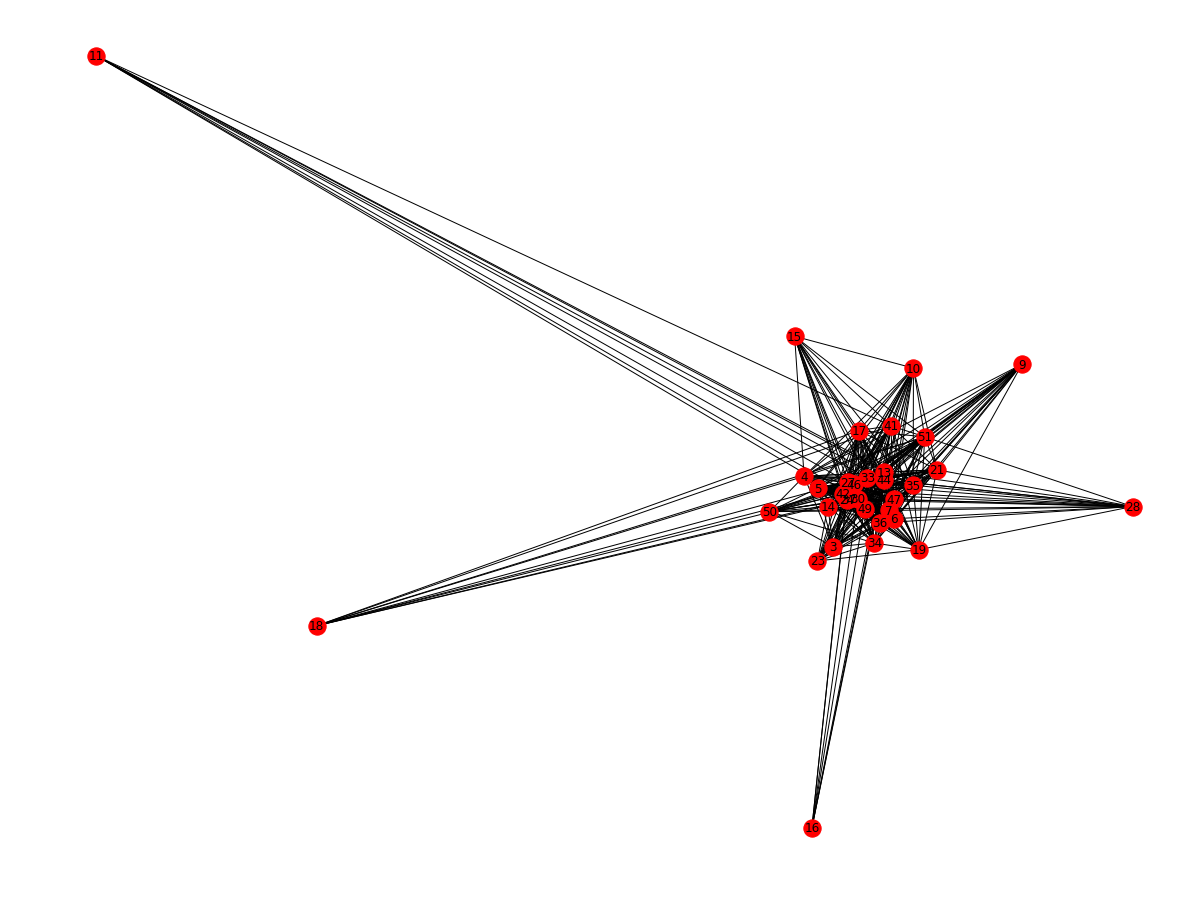

[('28', 17), ('36', 27), ('24', 32), ('23', 19), ('27', 31), ('21', 28), ('49', 32), ('46', 29), ('47', 26), ('44', 33), ('42', 29), ('41', 24), ('3', 22), ('5', 27), ('4', 28), ('7', 27), ('6', 28), ('9', 21), ('11', 8), ('10', 21), ('13', 32), ('15', 16), ('14', 27), ('17', 28), ('16', 7), ('33', 31), ('18', 9), ('30', 32), ('51', 28), ('50', 15), ('35', 30), ('34', 25), ('19', 23), ('37', 28)]
[('28', 2667), ('36', 135871), ('24', 168705), ('23', 44246), ('27', 147500), ('21', 48280), ('49', 269703), ('46', 185065), ('47', 116086), ('44', 289497), ('42', 166853), ('41', 64427), ('3', 68015), ('5', 92047), ('4', 79568), ('7', 113432), ('6', 116609), ('9', 4874), ('11', 58), ('10', 18309), ('13', 215861), ('15', 9428), ('14', 115385), ('17', 86062), ('16', 627), ('33', 237177), ('18', 195), ('30', 141636), ('51', 89607), ('50', 26927), ('35', 88509), ('34', 105231), ('19', 46703), ('37', 145064)]
[('28', 64), ('36', 2195), ('24', 3937), ('23', 628), ('27', 3695), ('21', 786), ('49', 4

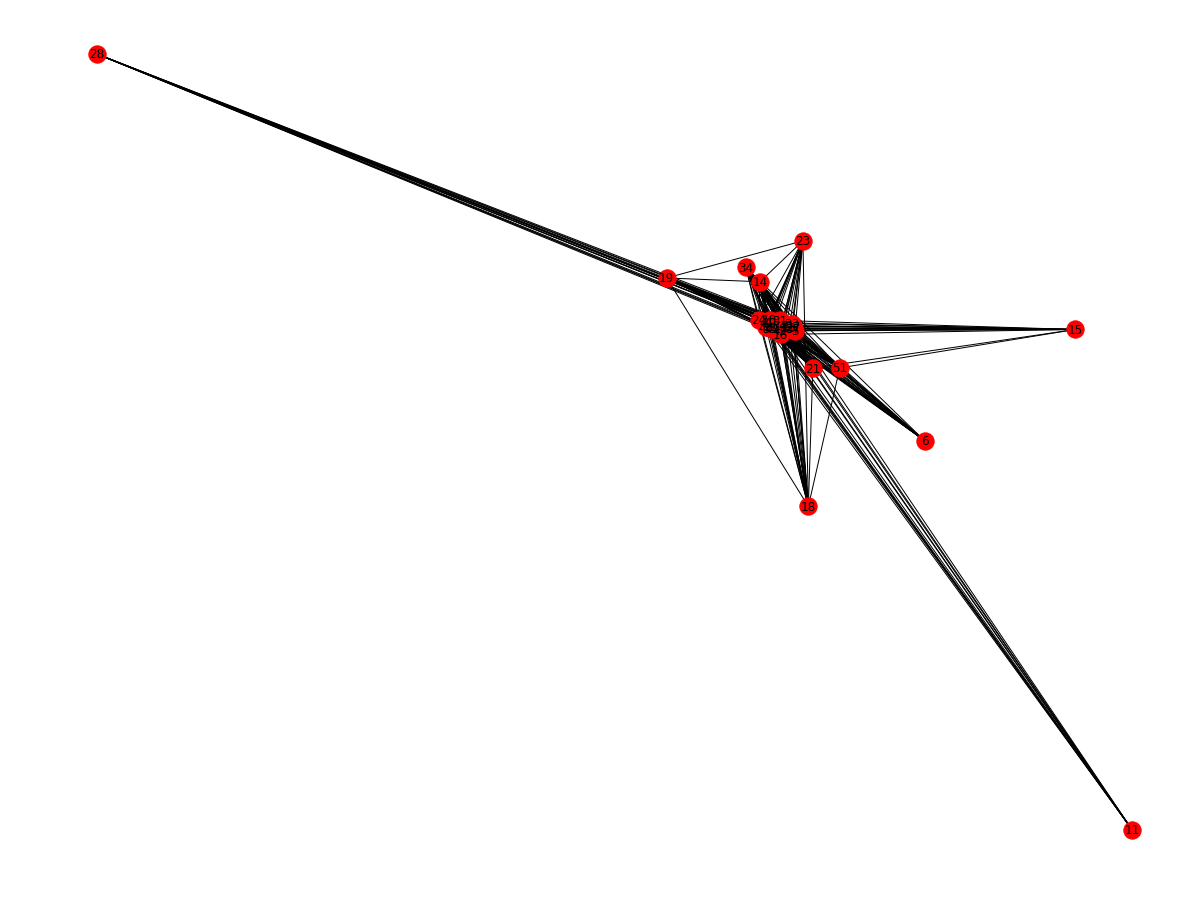

[('30', 26), ('28', 14), ('24', 23), ('27', 28), ('21', 22), ('49', 28), ('46', 27), ('44', 28), ('42', 26), ('41', 28), ('5', 26), ('4', 27), ('6', 19), ('11', 11), ('10', 24), ('13', 28), ('15', 16), ('14', 22), ('17', 28), ('16', 28), ('33', 27), ('18', 24), ('31', 24), ('23', 19), ('51', 19), ('35', 27), ('34', 23), ('19', 16), ('37', 24)]
[('30', 279348), ('28', 259), ('24', 184121), ('27', 316752), ('21', 114269), ('49', 351605), ('46', 364897), ('44', 442016), ('42', 332919), ('41', 374022), ('5', 292700), ('4', 277118), ('6', 8158), ('11', 195), ('10', 246528), ('13', 392138), ('15', 5374), ('14', 87510), ('17', 294155), ('16', 374025), ('33', 311070), ('18', 5684), ('31', 196351), ('23', 42806), ('51', 63958), ('35', 204719), ('34', 77666), ('19', 71670), ('37', 257505)]
[('30', 4310), ('28', 44), ('24', 3969), ('27', 5314), ('21', 1964), ('49', 6857), ('46', 5738), ('44', 6335), ('42', 4957), ('41', 8653), ('5', 11513), ('4', 11196), ('6', 315), ('11', 13), ('10', 5115), ('13

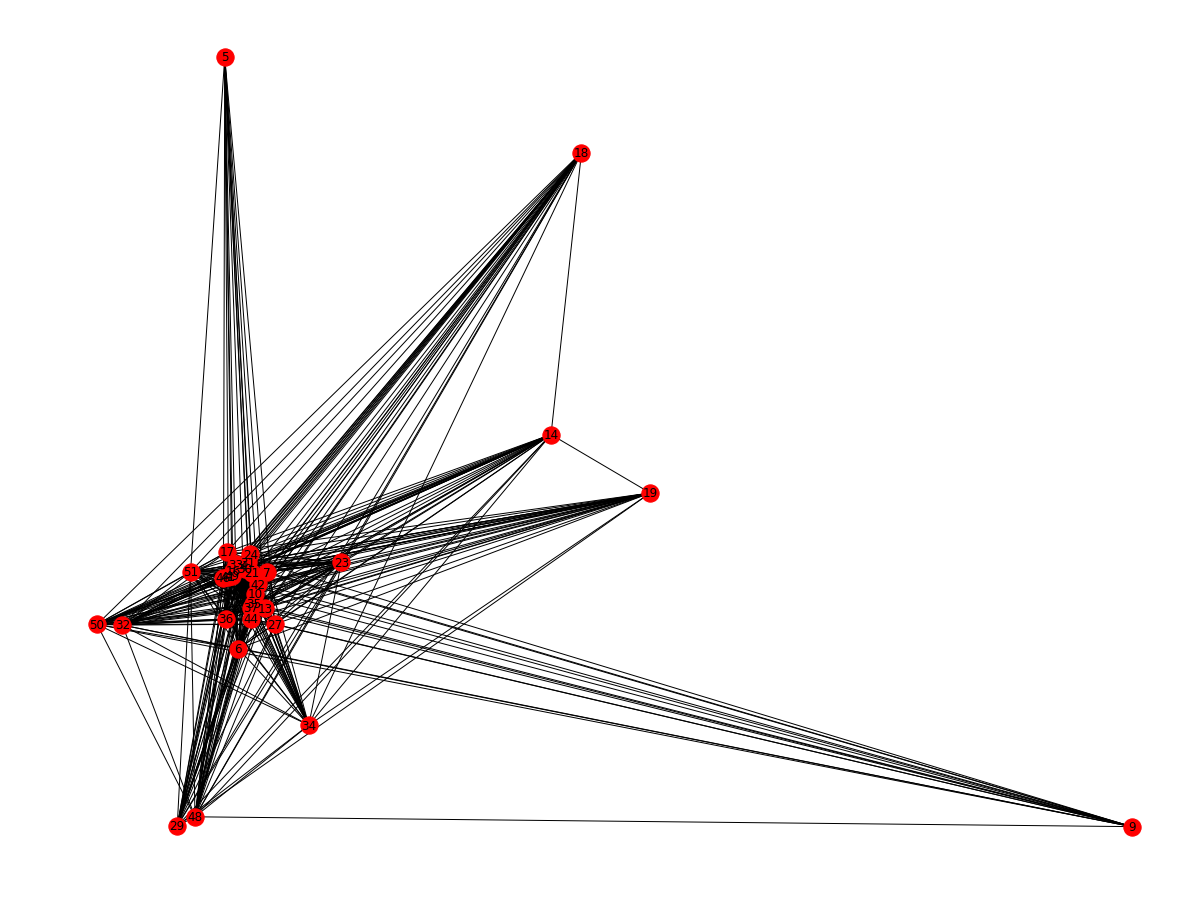

[('30', 30), ('37', 32), ('36', 30), ('24', 30), ('27', 32), ('21', 30), ('48', 30), ('49', 32), ('46', 32), ('44', 31), ('42', 31), ('29', 27), ('41', 31), ('5', 14), ('4', 31), ('7', 31), ('6', 31), ('9', 15), ('10', 31), ('13', 32), ('14', 28), ('17', 31), ('16', 31), ('33', 31), ('18', 29), ('31', 28), ('23', 29), ('51', 31), ('50', 29), ('35', 32), ('34', 29), ('19', 28), ('32', 29)]
[('30', 227276), ('37', 325177), ('36', 145509), ('24', 179454), ('27', 310216), ('21', 212044), ('48', 62670), ('49', 387472), ('46', 188200), ('44', 167870), ('42', 267908), ('29', 35935), ('41', 323377), ('5', 3944), ('4', 140323), ('7', 151536), ('6', 168393), ('9', 987), ('10', 263843), ('13', 333724), ('14', 18384), ('17', 305274), ('16', 406914), ('33', 142118), ('18', 4288), ('31', 216596), ('23', 108418), ('51', 120701), ('50', 70385), ('35', 247751), ('34', 75976), ('19', 11852), ('32', 86633)]
[('30', 5829), ('37', 8851), ('36', 3976), ('24', 3779), ('27', 6046), ('21', 4311), ('48', 1336),

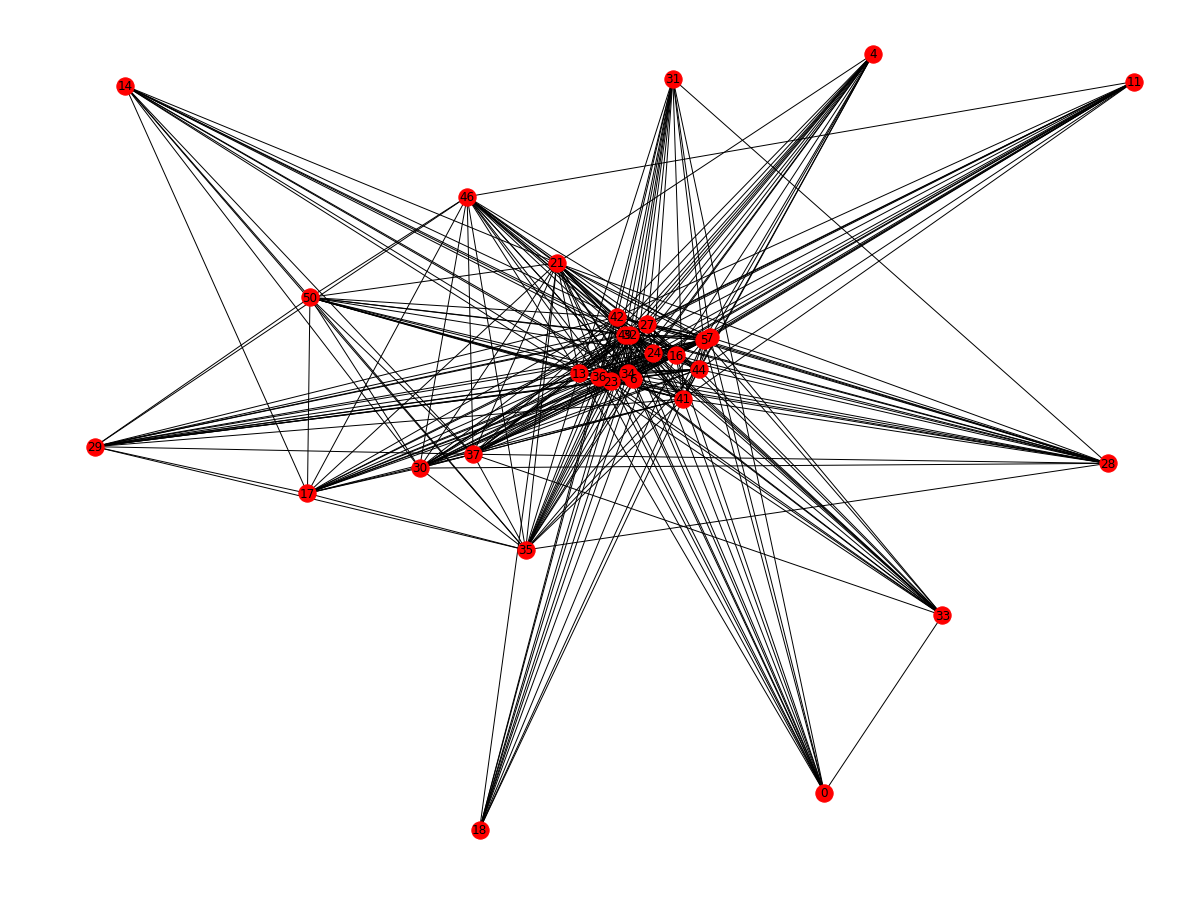

[('42', 30), ('36', 29), ('49', 28), ('24', 30), ('27', 24), ('21', 24), ('23', 29), ('46', 21), ('44', 22), ('28', 19), ('29', 18), ('41', 29), ('0', 15), ('5', 26), ('4', 16), ('7', 22), ('6', 30), ('11', 16), ('13', 29), ('14', 14), ('17', 18), ('16', 20), ('33', 16), ('32', 30), ('31', 15), ('30', 21), ('37', 24), ('50', 18), ('35', 22), ('34', 30), ('18', 11)]
[('42', 349980), ('36', 264275), ('49', 208728), ('24', 311030), ('27', 177851), ('21', 69807), ('23', 214503), ('46', 28221), ('44', 126031), ('28', 6141), ('29', 7278), ('41', 256520), ('0', 6057), ('5', 175659), ('4', 12082), ('7', 152113), ('6', 199160), ('11', 3212), ('13', 316919), ('14', 4352), ('17', 14461), ('16', 143759), ('33', 11433), ('32', 325881), ('31', 26455), ('30', 49175), ('37', 102514), ('50', 16121), ('35', 31774), ('34', 261613), ('18', 4157)]
[('42', 6782), ('36', 4774), ('49', 4411), ('24', 7706), ('27', 4215), ('21', 1777), ('23', 3339), ('46', 480), ('44', 2317), ('28', 115), ('29', 101), ('41', 54

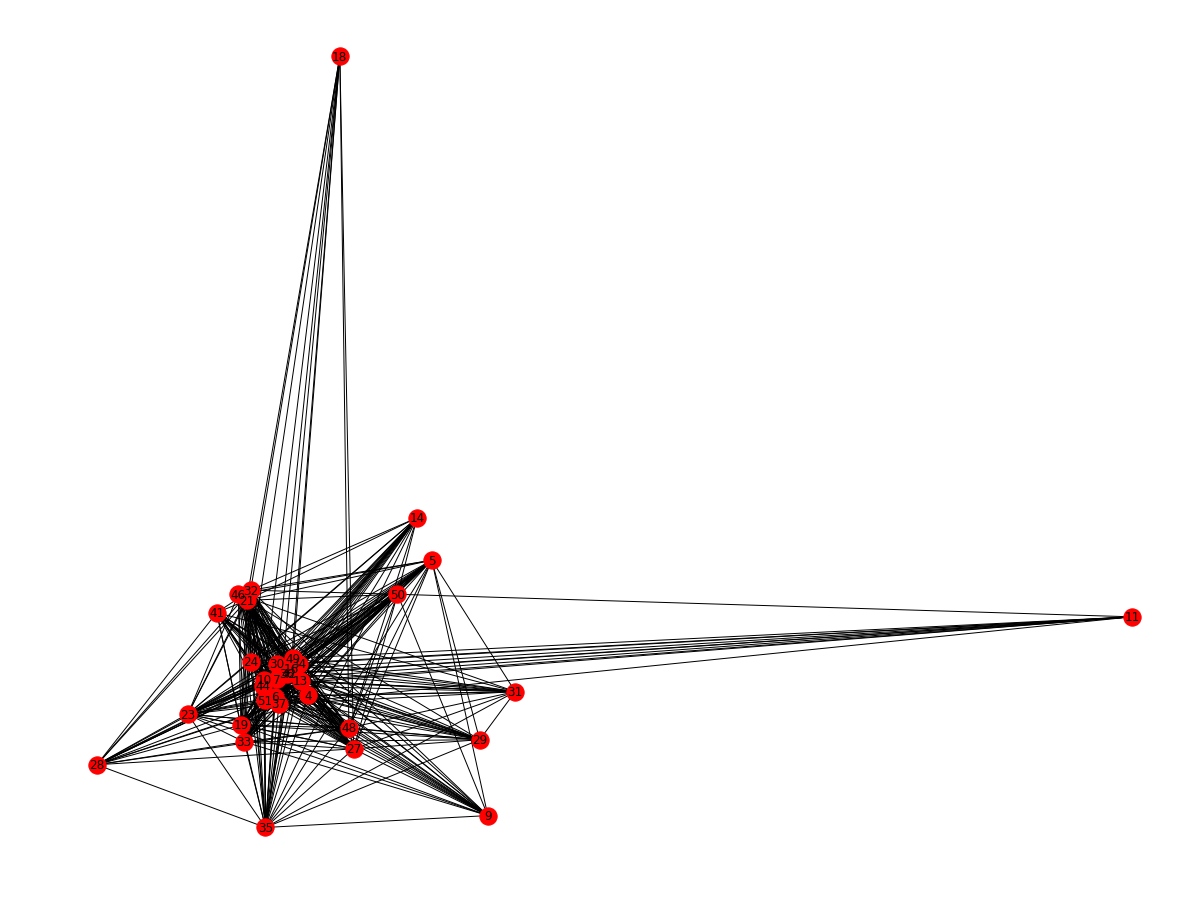

[('30', 31), ('37', 33), ('36', 31), ('24', 28), ('27', 31), ('21', 30), ('48', 32), ('49', 33), ('46', 26), ('44', 33), ('42', 30), ('29', 20), ('41', 23), ('5', 27), ('4', 31), ('7', 31), ('6', 31), ('9', 20), ('28', 18), ('11', 11), ('10', 31), ('13', 30), ('14', 23), ('16', 32), ('19', 30), ('32', 30), ('31', 18), ('23', 27), ('51', 27), ('50', 24), ('35', 29), ('34', 31), ('33', 30), ('18', 10)]
[('30', 172767), ('37', 243700), ('36', 176246), ('24', 170873), ('27', 76861), ('21', 95094), ('48', 67925), ('49', 289087), ('46', 45718), ('44', 295913), ('42', 279910), ('29', 16832), ('41', 84030), ('5', 32550), ('4', 163324), ('7', 145329), ('6', 126671), ('9', 10123), ('28', 13552), ('11', 288), ('10', 210775), ('13', 241768), ('14', 18588), ('16', 335130), ('19', 121533), ('32', 104656), ('31', 18702), ('23', 47561), ('51', 110782), ('50', 28931), ('35', 40971), ('34', 234058), ('33', 109718), ('18', 558)]
[('30', 4693), ('37', 7347), ('36', 5196), ('24', 4165), ('27', 2804), ('21'

In [90]:
for i in range(len(all_graphs['night'])):
    print(i)
    for g, nd in [(all_graphs['night'][i]['same_side'], 'night'), (all_graphs['day'][i]['same_side'], 'day')]:
        print(nd)
        
        G = nx.Graph()
        for n1, n2, d in g.edges(data=True):
            if G.has_edge(n1,n2):
                G[n1][n2]['weight'] += d['weight']
                G[n1][n2]['num_interactions'] += 1
            else:
                G.add_edge(n1, n2, weight=d['weight'], num_interactions=1)

        plt.figure(figsize=(16,12))
        nx.draw(G, with_labels=True)
        plt.show()
        
        print(G.degree())
        print(G.degree(weight='weight'))
        print(G.degree(weight='num_interactions'))

In [ ]:
# G.neighbors(n) # neighbours of node - number of neighbors that a node has is called its "degree"
# nx.degree_centrality(G) returns the degree centrality of all nodes (self loops are not counted)

#degree of a node is the number of neighbors that it has.
degrees = [len(T.neighbors(n)) for n in T.nodes()]

# The degree centrality is the number of neighbors divided by all possible neighbors that it could have
# function returns a dictionary, where the keys are the nodes and the values are their degree centrality values.
nx.degree_centrality(G)

plt.figure()
plt.hist(list(deg_cent.values()))
plt.show()

# Betweenness centrality
# Betwenness centrality is the number of shortest paths through node, divided by all shortest paths
# This captures bottlenecked nodes in a graph, rather just highly connected ones
bet_cen = nx.betweenness_centrality(T)
nx.average_clustering(G)

nx.isolates(G)



# Calculate the largest connected component subgraph: largest_ccs
# Python's built-in sorted() function takes an iterable and returns a sorted list (in ascending order, by default).
# Therefore, to access the largest connected component subgraph, the statement is sliced with [-1].
largest_ccs = sorted(nx.connected_component_subgraphs(G), key=lambda x: len(x))[-1]

when node disappears completely

plt.figure()
plt.scatter(list(bet_cen.values()), list(deg_cen.values()))
plt.show()

In [ ]:
#Subgraphs - Extract sections of large graph to explore/visualise

nodes_of_interest = [29, 38, 42]

# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
    
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
        
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
            
    return G.subgraph(nodes_to_draw)

# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes_and_nbrs(T, nodes_of_interest)

# Draw the subgraph to the screen
nx.draw(T_draw)
plt.show()


# Extract the nodes of interest: nodes
nodes = [n for n, d in T.nodes(data=True) if d['occupation'] == 'celebrity']

# Create the set of nodes: nodeset
nodeset = set(nodes)

# Iterate over nodes
for n in nodes:

    # Compute the neighbors of n: nbrs
    nbrs = T.neighbors(n)
    
    # Compute the union of nodeset and nbrs: nodeset
    nodeset = nodeset.union(nbrs)

# Compute the subgraph using nodeset: T_sub
T_sub = T.subgraph(nodeset)

# Draw T_sub to the screen
nx.draw(T_sub)
plt.show()




nx.draw(G, with_labels=True)
plt.show()

nx.draw_circular(G, with_labels=True, node_color='bisque')
plt.show()

# Clustering coefficient: Actual number of friendships / total possibility friendships
# Number of links that neighbours have with each other, dividied by number of possible links of all neighbours
# Tells you how closely knit the friends of a network are
# nx.clustering(G) is used for clustering of entire network, gives dictionary with values for every node



# Use a list comprehension to get the nodes of interest: noi
# 'occupation' label of 'scientist'
noi = [n for n, d in T.nodes(data=True) if d['occupation'] == 'scientist']

# Use a list comprehension to get the edges of interest: eoi
# list of edges from the graph T that were formed for at least 6 years, i.e., from before 1 Jan 2010
eoi = [(u, v) for u, v, d in T.edges(data=True) if d['date'] < date(2010, 1, 1)]




# Set the weight of the edge
T.edge[1][10]['weight'] = 2

# Iterate over all the edges (with metadata)
for u, v, d in T.edges(data=True):
    print(v)
    # Check if node 293 is involved
    # If 293 is involved in the list of nodes [u, v]
    if 293 in [u, v]:
    
        # Set the weight to 1.1
        T.edge[u][v]['weight'] = 1.1

## Perimeter Metrics

In [ ]:
unique_perimeter_centers = []
grouped_perimeters = {'unique_center_index': [], 'seconds_present': [], 'distances_per_second': [], 'night_or_day': [], 'time_period_num': []}

for i in range(len(tag_class_circadian_metrics[constants.QUEEN_CLASS]['night'])):
    night_metrics = tag_class_circadian_metrics[constants.QUEEN_CLASS]['night'][i]
    day_metrics = tag_class_circadian_metrics[constants.QUEEN_CLASS]['day'][i]
    
    night_period_str = str(i) + '_0_' + 'night'
    day_period_str = str(i) + '_1_' + 'day'
    night_bg_image = night_day_bg_images['night'][i]
    day_bg_image = night_day_bg_images['day'][i]
    
    night_perimeter_xs = []
    night_perimeter_ys = []
    for p in night_metrics['all_perimeter_data']:
        night_perimeter_xs.append(p['center_coord']['x'])
        night_perimeter_ys.append(p['center_coord']['y'])
        
    day_perimeter_xs = []
    day_perimeter_ys = []
    for p in day_metrics['all_perimeter_data']:
        day_perimeter_xs.append(p['center_coord']['x'])
        day_perimeter_ys.append(p['center_coord']['y'])
        
    file_name = os.path.join(path_bg_dir, night_period_str + '.png')
    plot_path_bg(night_perimeter_xs, night_perimeter_ys, night_bg_image, file_name)
    
    file_name = os.path.join(path_bg_dir, day_period_str + '.png')
    plot_path_bg(day_perimeter_xs, day_perimeter_ys, day_bg_image, file_name)

    
    for p in night_metrics['all_perimeter_data']:
        grouped_perimeters['seconds_present'].append(p['seconds_present'])
        grouped_perimeters['distances_per_second'].append(np.median(p['distances_per_second']))
        grouped_perimeters['night_or_day'].append('night')
        grouped_perimeters['time_period_num'].append(i)
        
        cc = p['center_coord']
        
        is_unique = True
        for j, uc in enumerate(unique_perimeter_centers):
            if calc_distance(cc['x'], cc['y'], uc['x'], uc['y']) < constants.PERIMETER_RADIUS:
                grouped_perimeters['unique_center_index'].append(j)
                
                is_unique = False
                break
        
        if is_unique:
            unique_perimeter_centers.append(cc)
            grouped_perimeters['unique_center_index'].append(len(unique_perimeter_centers) - 1)
    
    for p in day_metrics['all_perimeter_data']:
        grouped_perimeters['seconds_present'].append(p['seconds_present'])
        grouped_perimeters['distances_per_second'].append(np.median(p['distances_per_second']))
        grouped_perimeters['night_or_day'].append('day')
        grouped_perimeters['time_period_num'].append(i)
        
        cc = p['center_coord']
        
        is_unique = True
        for j, uc in enumerate(unique_perimeter_centers):
            if calc_distance(cc['x'], cc['y'], uc['x'], uc['y']) < constants.PERIMETER_RADIUS:
                grouped_perimeters['unique_center_index'].append(j)
                
                is_unique = False
                break
        
        if is_unique:
            unique_perimeter_centers.append(cc)
            grouped_perimeters['unique_center_index'].append(len(unique_perimeter_centers) - 1)

In [92]:
visits = {'time_period_num': [], 'day_or_night': [], 'num_visits': [], 'median_visit_length': []}
'''
for n, uc_df in df.groupby('unique_center_index'):
    num_visits = len(uc_df['unique_center_index'])
    #median_visit_length = np.median(uc_df['seconds_present'])
    median_visit_length = list(uc_df['seconds_present'])
    visits['time_period_num'].append(name)
    visits['day_or_night'].append('day')
    visits['num_visits'].append(num_visits)
    visits['median_visit_length'].append(median_visit_length)

'''
time_period_group = df.groupby('time_period_num')
for name, time_df in time_period_group:
    
    night_df = time_df[time_df['night_or_day'] == 'night']
    day_df = time_df[time_df['night_or_day'] == 'day']
    
    night_uc_group = night_df.groupby('unique_center_index')
    day_uc_group = day_df.groupby('unique_center_index')
    
    for n, uc_df in night_uc_group:
        num_visits = len(uc_df['unique_center_index'])
        #median_visit_length = np.median(uc_df['seconds_present'])
        median_visit_length = np.mean(uc_df['seconds_present'])
        visits['time_period_num'].append(name)
        visits['day_or_night'].append('night')
        visits['num_visits'].append(num_visits)
        visits['median_visit_length'].append(median_visit_length)
        
    for n, uc_df in day_uc_group:
        num_visits = len(uc_df['unique_center_index'])
        #median_visit_length = np.median(uc_df['seconds_present'])
        median_visit_length = np.mean(uc_df['seconds_present'])
        visits['time_period_num'].append(name)
        visits['day_or_night'].append('day')
        visits['num_visits'].append(num_visits)
        visits['median_visit_length'].append(median_visit_length)
#'''

In [93]:
visits_df = pd.DataFrame(visits)
visits_df

plot_scatter(visits_df['num_visits'], visits_df['median_visit_length'], 'Times Returning to Region', 'Number of visits', 'Median Visit Length', 'visits.png')

In [74]:
visits_df

,day_or_night,median_visit_length,num_visits,time_period_num
0,day,88.5,20,0
1,day,34.0,12,0
2,day,124.5,14,0
3,day,51.0,9,0
4,day,62.0,21,0
5,day,46.0,13,0
6,day,54.0,15,0
7,day,49.0,6,0
8,day,81.0,10,0
9,day,689.5,2,0


In [76]:
df[df['unique_center_index']==4]

,distances_per_second,night_or_day,seconds_present,time_period_num,unique_center_index
15,6.576915,day,27,0,4
19,13.453624,day,76,0,4
21,12.883498,day,57,0,4
23,3.605551,day,118,0,4
24,9.055385,day,165,0,4
26,1.414214,day,739,0,4
27,11.704700,day,35,0,4
28,12.529964,day,62,0,4
35,1.000000,day,1031,0,4
36,1.000000,day,1110,0,4


In [75]:
df['unique_center_index'].value_counts()

4     157
0     147
14    147
5     120
39    120
36    111
9     101
37     99
12     98
2      97
7      95
21     94
18     87
1      83
38     78
25     78
16     77
31     76
8      76
6      74
3      74
17     72
34     64
13     63
15     63
10     60
19     57
40     54
42     53
53     48
     ... 
76      9
57      8
59      8
29      7
66      6
68      6
71      6
67      6
78      4
84      4
58      3
62      3
77      3
26      3
30      3
81      3
72      2
75      2
64      2
55      2
63      2
73      2
65      2
85      1
74      1
80      1
82      1
83      1
79      1
86      1
Name: unique_center_index, Length: 87, dtype: int64

In [41]:
df = pd.DataFrame(grouped_perimeters)

,distances_per_second,night_or_day,seconds_present,time_period_num,unique_center_index
0,4.242641,day,51,0,0
1,1.414214,day,92,0,0
2,3.605551,day,173,0,1
3,1.000000,day,837,0,2
4,1.414214,day,346,0,2
5,6.737096,day,79,0,0
6,9.667845,day,85,0,0
7,7.941218,day,40,0,0
8,1.414214,day,220,0,0
9,1.000000,day,1141,0,0


In [45]:
print('Overall:', len(df['unique_center_index']) / float(len(df['unique_center_index'].unique())))
print(df['time_period_num'].unique())

time_period_group = df.groupby('time_period_num')
for name, time_df in time_period_group:
    night_df = time_df[time_df['night_or_day'] == 'night']
    day_df = time_df[time_df['night_or_day'] == 'day']
    
    night_returns = 0
    day_returns = 0
    time_period_returns = 0
    
    if len(time_df['unique_center_index']) > 0:
        time_period_returns = len(time_df['unique_center_index']) / float(len(time_df['unique_center_index'].unique()))
    if len(night_df['unique_center_index']) > 0:
        night_returns = len(night_df['unique_center_index']) / float(len(night_df['unique_center_index'].unique()))
    if len(day_df['unique_center_index']) > 0:
        day_returns = len(day_df['unique_center_index']) / float(len(day_df['unique_center_index'].unique()))
    
    print(name, time_period_returns, night_returns, day_returns)


('Overall:', 38.81609195402299)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
(0, 7.2, 0, 7.2)
(1, 4.0, 2.5588235294117645, 3.129032258064516)
(2, 3.8771929824561404, 3.8, 1.5151515151515151)
(3, 3.411764705882353, 2.8222222222222224, 1.9811320754716981)
(4, 3.9696969696969697, 2.739130434782609, 2.6153846153846154)
(5, 4.978260869565218, 4.0, 2.4545454545454546)
(6, 4.8431372549019605, 2.1470588235294117, 3.9545454545454546)
(7, 3.8333333333333335, 2.235294117647059, 3.0)
(8, 4.56140350877193, 3.0625, 2.6904761904761907)
(9, 4.170212765957447, 2.7, 2.6666666666666665)
(10, 5.3, 3.341463414634146, 3.3684210526315788)
(11, 4.696969696969697, 4.038461538461538, 2.6315789473684212)
(12, 7.419354838709677, 4.388888888888889, 5.392857142857143)
(13, 7.0, 4.59375, 3.25)
(14, 6.0, 4.958333333333333, 3.3448275862068964)
(15, 4.543478260869565, 3.3448275862068964, 2.871794871794872)
